# 프로젝트
* User가 등록한 item과 유사한 item top k개를 추천한다.

## How?

1. polyvore dataset의 각 item의 feature vector를 저장한다.
2. user가 등록한 item의 feature vector를 저장한다.
3. user가 등록한 item과 polyvore dataset item 중에서 코사인 유사도가 가장 가까운 item top k개를 뽑는다.

### 라이브러리, 모듈 import

In [1]:
import os
import sys
import numpy as np
import pickle

import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.color import gray2rgb, rgba2rgb
import skimage.io

import json

import matplotlib.pyplot as plt
import cv2

* gpu 동작확인

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### cosine similarity function (유사도 측정 함수)

In [3]:
def cos_sim(A, B):
    return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

### test cosine similarity function
print(cos_sim([1,2,3,4,5,6,7,1,2,3], [1,2,3,4,5,6,3,56,1,2]))

0.24912240729730595


### polyvore item feature vector 불러오기

* 저장된 pkl file은 딕셔너리 형태로 저장이 되어 있음
    * key: 각 item의 id
    * value: 각 item의 feature vector

In [4]:
root_path = "../../experiment/"
feature_path="data/polyvore/dataset/"

### 미리 학습한 training set에 있는 item들의 feature vector
with open(root_path+feature_path+'imgs_featdict_train.pkl', 'rb') as train_feat:
    train_data = pickle.load(train_feat)

### 미리 학습한 validation set에 있는 item들의 feature vector
with open(root_path+feature_path+'imgs_featdict_valid.pkl', 'rb') as valid_feat:
    valid_data = pickle.load(valid_feat)
    
### 미리 학습한 test set에 있는 item들의 feature vector
with open(root_path+feature_path+'imgs_featdict_test.pkl', 'rb') as test_feat:
    test_data = pickle.load(test_feat)

* training, validation, test set에 있는 모든 item을 딕셔너리 형태로 저장해야한다.
    * 각 item의 id와 feature vector를 각각 저장해야한다.

In [5]:
save_feat =[]    ### save_id: 각 item을 구별할 수 있는 id만 저장하기 위한 list
save_id = []     ### save_feat: 각 item의 feature vector만 저장하기 위한 list

### train  
for key, value in train_data.items():
    save_feat.append(value)
    save_id.append(key)

### validation
for key, value in valid_data.items():
    save_feat.append(value)
    save_id.append(key)

### test
for key, value in test_data.items():
    save_feat.append(value)
    save_id.append(key)

print(save_id[0])   
print(save_feat[0])

194508109
[0.18897232 1.1840692  0.48277342 ... 0.35364604 0.02872582 0.88352245]


### dataset의 모든 item의 id와 feature vector를 저장
* key: item_id, value: item_feature_vector

In [6]:
data_dict ={}
print(len(save_id))

for i in range(len(save_id)):
    data_dict[save_id[i]] = save_feat[i]

print(data_dict['194508109'])

111589
[0.18897232 1.1840692  0.48277342 ... 0.35364604 0.02872582 0.88352245]


### user가 등록한 item의 feature vector 추출
* user가 등록한 item을 불러온다.

(-0.5, 255.5, 255.5, -0.5)

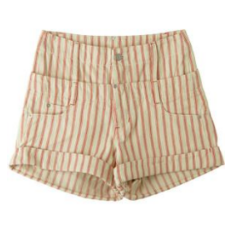

In [33]:
### 임의의 user item 등록
item='./sample_img/4.jpg'

### 등록 이미지 출력
img = cv2.imread(item)
img = cv2.resize(img, dsize=(256,256), interpolation=cv2.INTER_AREA)
img = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
    

### user가 등록한 item의 feature vector 추출
* resnet50 model을 통해 feature vector를 추출한다.


In [34]:
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
model.eval()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(256), transforms.CenterCrop(224),
                transforms.ToTensor(), normalize
            ])

### image feature vector를 추출하기 위한 함수

In [35]:
def process_image(im):
    im = transform(im)
    im = im.unsqueeze_(0)
    im = im.to(device)
    out = model(im)
    return out.squeeze()

### user item feature vector 추출

In [36]:
with torch.no_grad():
    im = skimage.io.imread(item)
    if len(im.shape) == 2:
        im=gray2rgb(im)
    if im.shape[2] == 4:
        im=rgba2rgb(im)
    
    im = resize(im, (256,256))
    im =img_as_ubyte(im)
    
    feats = process_image(im).cpu().numpy()

print(feats)
print(np.shape(feats))

[0.72432643 1.0194083  0.43575427 ... 0.0908255  0.20514083 0.91881245]
(2048,)


### cosine 유사도를 통해 유사한 item 추출
* res_list
    * user가 등록한 item과 data의 item간의 유사도를 저장
* res_dict
    * key: item, value: similarity score로 저장

In [37]:
res_list = []    ### res_list에는 user의 item과 data의 item의 유사도를 저장한다.  
res_dict = {}    ### key: polyvore item, value: similarity score

for i in range(len(save_feat)):
    res = cos_sim(feats,save_feat[i])
    res_list.append(res)
    res_dict[save_id[i]] = res_list[i]

print(res_dict['194508109'])

0.71278894


* sort_list
    * 유사도가 높은 순으로 정렬

In [38]:
### sort
sort_list = sorted(res_dict.items(), key=lambda item:item[1], reverse=True)

### sorting이 잘 되었는지 확인
print(sort_list)

[('133109456', 0.89952177), ('115202838', 0.89585143), ('137838575', 0.895556), ('97598059', 0.8925781), ('113955827', 0.8901312), ('105601806', 0.8897635), ('129522072', 0.88946146), ('100777320', 0.8865909), ('100915915', 0.88568217), ('181386550', 0.88511306), ('168725851', 0.8845588), ('122835610', 0.88311267), ('175235460', 0.88015765), ('125586185', 0.8792237), ('161136578', 0.87917614), ('89565134', 0.8790532), ('197552252', 0.8762397), ('179156371', 0.8761467), ('99040825', 0.8760045), ('99252081', 0.875677), ('37640192', 0.8755255), ('179037952', 0.87507063), ('173560794', 0.8735825), ('132762462', 0.8734042), ('166295298', 0.87316847), ('107866078', 0.8729223), ('107935588', 0.87275803), ('55402443', 0.8716872), ('114431240', 0.8713459), ('126687880', 0.87089837), ('119586183', 0.87054604), ('168670796', 0.87014705), ('141849130', 0.8699234), ('175602327', 0.8691457), ('178506946', 0.86861753), ('187000841', 0.86826056), ('172875620', 0.8678184), ('191702207', 0.86772615), ('

### data json 파일에서 image 불러오기
* 가장 높은 유사도를 갖는 item의 id를 확인
* train, valid, test 파일에 저장된 data에 해당 item의 id가 있는지 확인하고
* 그 item의 index번호를 확인하고
* 해당 item을 갖는 outfit의 id를 확인하고
* local 폴더에서 outfit id를 찾고
* 해당 폴더 안에서 index.jpg 아이템을 불러온다.

In [39]:
### data json file 불러오기
train_json = 'data/polyvore/jsons/train_no_dup.json'
valid_json = 'data/polyvore/jsons/valid_no_dup.json'
test_json = 'data/polyvore/jsons/test_no_dup.json'

### 1. 가장 높은 유사도를 갖는 item의 id를 확인 (k개, 일단 3개)

In [40]:
best_sim_list = []
k = 3

for i in range (k):
    best_sim_list.append(sort_list[i][0])

print(best_sim_list)

['133109456', '115202838', '137838575']


### 2. train, valid, test 파일에 저장된 data에 해당 item의 id가 있는지 확인

* 이 후에 그 item이 outfit에서 몇번째 index이며, item의 id가 무엇인지를 저장해야됨
* train, valid, test json file에서 새롭게 딕셔너리 형태로 저장을한다.
    * key: outfit_id
    * value: item_id, index_id

In [41]:
outfit2item = {}
outfit2index = {}

######################################################
###                json data load                  ###
######################################################
### train.json에 대하여...
with open(root_path+train_json, "r") as train_file:
    train_in_outfit_id = json.load(train_file)

### valid.json에 대하여...
with open(root_path+valid_json, "r") as valid_file:
    valid_in_outfit_id = json.load(valid_file)

### test.json에 대하여...
with open(root_path+test_json, "r") as test_file:
    test_in_outfit_id = json.load(test_file)
#######################################################


################################################################################
###        각 outfit 마다 item_id와 index를 딕셔너리 형태로 각각 저장        ###
################################################################################

### 17,316개의 outfit을 갖고 있는 train set에ㅔ 대하여...
for i in range(len(train_in_outfit_id)):    ### len(train_in_outfit_id: 17316)
    outfit_id = train_in_outfit_id[i]["set_id"]
    
    item_index = []
    item_id = []
    
    for j in range(len(train_in_outfit_id[i]["items"])):
        index = train_in_outfit_id[i]["items"][j]["index"]
        item_index.append(index)
        _, each_item_id = train_in_outfit_id[i]["items"][j]["image"].split('id=')
        item_id.append(each_item_id)
        
    outfit2index[outfit_id] = item_index
    outfit2item[outfit_id] = item_id

### 1,497개의 outfit을 갖고 있는 validation set에 대하여...
for i in range(len(valid_in_outfit_id)):    ### len(train_in_outfit_id: 17316)
    outfit_id = valid_in_outfit_id[i]["set_id"]
    
    item_index = []
    item_id = []
    
    for j in range(len(valid_in_outfit_id[i]["items"])):
        index = valid_in_outfit_id[i]["items"][j]["index"]
        item_index.append(index)
        _, each_item_id = valid_in_outfit_id[i]["items"][j]["image"].split('id=')
        item_id.append(each_item_id)
        
    outfit2index[outfit_id] = item_index
    outfit2item[outfit_id] = item_id
    
### 3,076개의 outfit을 갖고 있는 test set에 대하여....
for i in range(len(test_in_outfit_id)):    ### len(train_in_outfit_id: 17316)
    outfit_id = test_in_outfit_id[i]["set_id"]
    
    item_index = []
    item_id = []
    
    for j in range(len(test_in_outfit_id[i]["items"])):
        index = test_in_outfit_id[i]["items"][j]["index"]
        item_index.append(index)
        _, each_item_id = test_in_outfit_id[i]["items"][j]["image"].split('id=')
        item_id.append(each_item_id)
        
    outfit2index[outfit_id] = item_index
    outfit2item[outfit_id] = item_id
################################################################################

In [42]:
### 딕셔너리가 잘 저장되었는지 확인
print(outfit2index['211686294'])
print(outfit2item['211686294'])

print(outfit2index['148787971'])
print(outfit2item['148787971'])

[1, 2, 3, 4, 5, 6, 7]
['177433619', '186517066', '186779723', '154161576', '156219830', '157705378', '191219571']
[1, 2, 3, 4, 5, 6, 7, 8]
['126319344', '115808504', '124973053', '125587844', '107656548', '122080392', '123823763', '125301380']


* 저장된 outfit2index, outfit2item json 파일에 저장

### 3. local image 폴더에 접근해서 image 파일 가져오기

In [43]:
image_folder_path = 'data/polyvore/images/'

* outfit2item의 value와 best_sim_list의 i번째 item이 같다면 outfit2item의 key를 가져온다.
* 해당 outfit_id의 index 위치를 받아온다.

In [44]:
find_outfit_id = []
find_index_id = []
# print(k)
for i in range(k):
    print("similariyt item: {}".format(best_sim_list[i]))
    print(len(outfit2item.keys()))
    for key in outfit2item.keys():
        for j in range(len(outfit2item[key])):
            if best_sim_list[i] == outfit2item[key][j]:
                find_outfit_id.append(str(key))
                find_index_id.append(str(j+1))
            continue
print(find_outfit_id)
print(find_index_id)

similariyt item: 133109456
21889
similariyt item: 115202838
21889
similariyt item: 137838575
21889
['157529048', '131642435', '175429464']
['2', '2', '2']


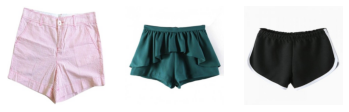

In [45]:
sim_test = []
for i in range(k):
    sim_test.append('data/polyvore/images/'+find_outfit_id[i]+'/'+find_index_id[i]+'.jpg')

### http://blog.daum.net/geoscience/1263 참고
fig = plt.figure()
rows = 1
cols = k
space = 1

for i in range(k):
    img = cv2.imread(root_path+sim_test[i])
    img = cv2.resize(img, dsize=(256,256), interpolation=cv2.INTER_AREA)
    ax = fig.add_subplot(rows,cols,space)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    space += 1
    ax.axis("off")
plt.show()

### 유사한 아이템 뽑아보기
* 직접 파일 찾아서 모듈이 제대로 뽑을 수 있는지 확인

In [46]:
sim1_item = 'data/polyvore/images/152844073/1.jpg'
sim2_item = 'data/polyvore/images/197554794/1.jpg'
sim3_item = 'data/polyvore/images/216497477/2.jpg'

### 각 image reshape
data_img1 = skimage.io.imread(root_path+sim1_item)
if len(data_img1.shape) == 2:
    data_img1=gray2rgb(data_img1)
if data_img1.shape[2] == 4:
    data_img1=rgba2rgb(data_img1)
data_img1 = resize(data_img1, (256,256)) 

data_img2 = skimage.io.imread(root_path+sim2_item)
if len(data_img2.shape) == 2:
    data_img2=gray2rgb(data_img2)
if data_img2.shape[2] == 4:
    data_img2=rgba2rgb(data_img2)
data_img2 = resize(data_img2, (256,256)) 

data_img3 = skimage.io.imread(root_path+sim3_item)
if len(data_img3.shape) == 2:
    data_img3=gray2rgb(data_img3)
if data_img3.shape[2] == 4:
    data_img3=rgba2rgb(data_img3)
data_img3 = resize(data_img3, (256,256)) 

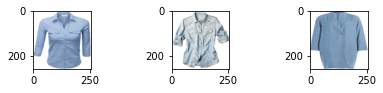

In [47]:
### 행, 열, 자리
plt.subplot(151)
plt.imshow(data_img1)

plt.subplot(153)
plt.imshow(data_img2)

plt.subplot(155)
plt.imshow(data_img3)
